In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")

In [2]:
data = pd.read_csv("data/2020oi_data.snana.txt", delimiter='\t')
data = data[data['MJD'] > 57000]
data = data[data['MAG'] > 0]

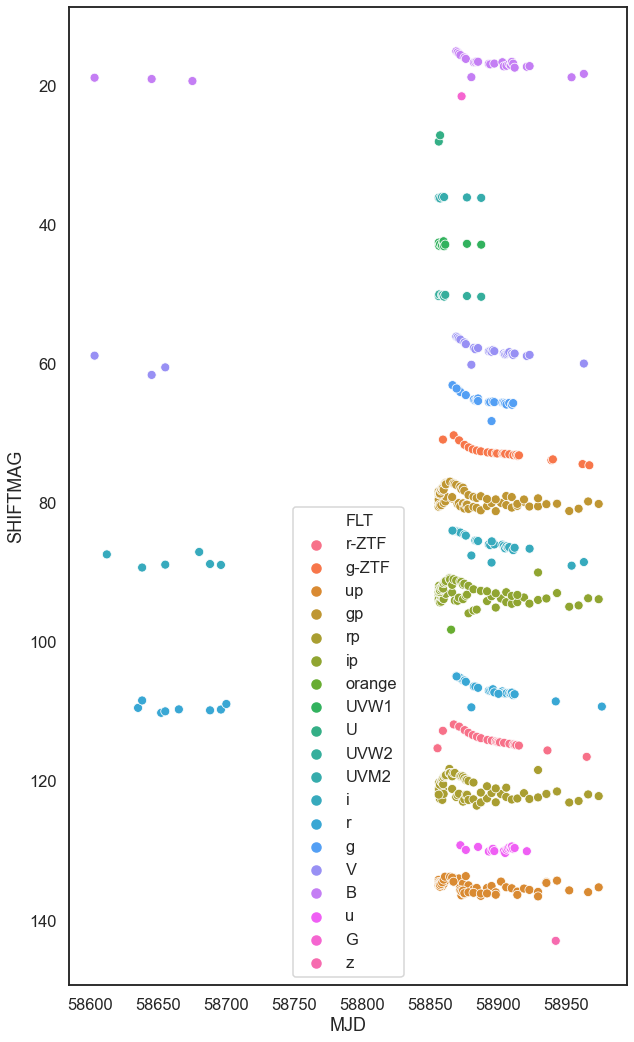

In [3]:
bands = np.unique(data['FLT'])
data['SHIFTMAG'] = data['MAG']
plt.figure(figsize=(10,18))
for i in np.arange(19):
    data.loc[data['FLT'] == bands[i], 'SHIFTMAG'] +=  7*i 
sns.scatterplot(x='MJD', y='SHIFTMAG', hue='FLT', data=data)
plt.gca().invert_yaxis()

In [4]:
Counter(data['INSTRUMENT'])

Counter({'ZTF-Cam': 48,
         'Sinistro': 323,
         'HKO': 1,
         'UVOT': 26,
         'GPC1': 8,
         'Direct/4Kx4K': 137,
         'Gaia-Photometric': 1,
         'Direct/2Kx2K': 31})

In [5]:
import os
from os import listdir
from os.path import isfile, join
from astropy.io import fits
import warnings
from astropy.utils.exceptions import AstropyUserWarning
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=AstropyUserWarning)
warnings.filterwarnings('ignore', category=AstropyWarning)

#rough position of the supernova at the center of the image, in pixels: 
#2251, 2251
XSN = 2251
YSN = 2251

timeArr = []
fixed_optical_df = []
zpts = []
zpts00 = []
path = "/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/"
files = [f for f in listdir(path) if isfile(join(path, f))]
#get the REAL photometry:
header_list = ['Xpos','Ypos','Mag','Mag_err','flux','flux_err', 'type', 'peakflux', 'sigx', 'sigxy', 'sigy', 'sky','chisqr','class','FWHM1','FWHM2','FWHM','angle','extendedness','flag','mask','Nmask','RA','Dec','pixchk_Npos','pixchk_Nneg','pixchk_Nmask','pixchk_Ntot','pixchk_Fpos','pixchk_Fneg']
dict_vals = {}
bands = []
for file in files:
    bands.append(file[7])
    hdul = fits.open("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file)
    temp = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/2020oi_photometry/%s"%file, names=header_list, skiprows=1, delim_whitespace=True)
    sub = temp[np.abs(temp['Xpos'] - XSN) + np.abs(temp['Xpos'] - YSN)  < 3]
    sub = sub[sub['peakflux'] == np.max(sub['peakflux'].values)]
    timeArr.append(hdul[0].header['MJD-OBS'])
    zpts.append(hdul[0].header['ZPTMAGAV'])
    if hdul[0].header['ZPTMAGAV'] < 1:
        print(file)
    zpts00.append(hdul[0].header['ZPTMAG00'])
    fixed_optical_df.append(sub)

2020oi.i.ut200216.4071_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200120.1130_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200314.3141_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp
2020oi.i.ut200301.8104_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.i.ut200204.3125_stch_1_i.2020oitmpl.18.stk_1.diff.dcmp
2020oi.r.ut200303.1098_stch_1_r.2020oitmpl.19.stk_1.diff.dcmp


In [6]:
fixed_optical_df = pd.concat(fixed_optical_df, ignore_index=True)
fixed_optical_df['time'] = timeArr
fixed_optical_df['zpt_av'] = zpts
fixed_optical_df['zpt_00'] = zpts00

fixed_optical_df['band'] = bands

In [7]:
#okay, so clearly lots of data, most of it useful. 
#let's fit one band - which has the most data?

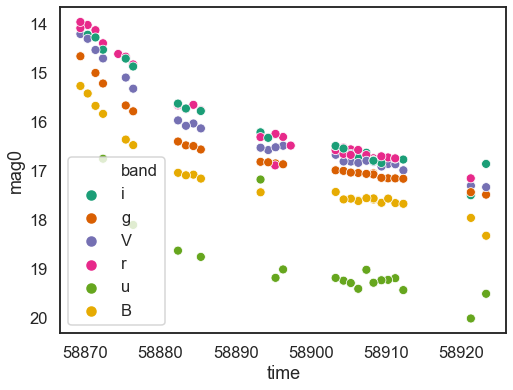

In [8]:
fixed_optical_df['mag0'] = -2.5*np.log10(fixed_optical_df['flux']) + fixed_optical_df['zpt_av']

#dropping the failed points for now
fixed_optical_df = fixed_optical_df[fixed_optical_df['mag0'] > 0]

plt.figure(figsize=(8,6))
sns.set_context("talk")
sns.scatterplot('time', 'mag0', hue='band', data=fixed_optical_df)
plt.gca().invert_yaxis()

fixed_optical_df['MJD'] = fixed_optical_df['time']
fixed_optical_df['MAG'] = fixed_optical_df['mag0']
fixed_optical_df['MAGERR'] = fixed_optical_df['Mag_err']
fixed_optical_df['FLT'] = fixed_optical_df['band']

newData = fixed_optical_df[['MJD', 'MAG', 'MAGERR', 'FLT']]

In [9]:
from collections import Counter
Counter(data['FLT'])

Counter({'r-ZTF': 24,
         'g-ZTF': 24,
         'up': 70,
         'gp': 86,
         'rp': 82,
         'ip': 85,
         'orange': 1,
         'UVW1': 10,
         'U': 2,
         'UVW2': 8,
         'UVM2': 6,
         'i': 36,
         'r': 37,
         'g': 24,
         'V': 30,
         'B': 30,
         'u': 18,
         'G': 1,
         'z': 1})

In [10]:

bands_list = [['rp', 'r-ZTF', 'r'], ['gp', 'g-ZTF', 'g'], ['B'], ['u', 'up'], ['U'], ['UVW2'], ['UVM2'], ['V'], ['i', 'ip']]
bands = ['rp', 'r-ZTF', 'r']

oneBand = data[data['FLT'].isin(bands)]
newData = newData[newData['FLT'].isin(bands)]
#instruments = ['Direct/4Kx4K', 'Sinistro']
#oneBand = oneBand[oneBand['INSTRUMENT'].isin(instruments)]
oneBand.sort_values(by=['MJD'], inplace=True)
oneBand = oneBand[oneBand['MAGERR'] < 0.03]
oneBand = oneBand[oneBand['MJD'] > 58800]

#combine online data plus newly reduced Swope photometry
oneBand = pd.concat([oneBand, newData])
#make sure our observations are unique
oneBand.drop_duplicates(subset=['MJD', 'MAG'], inplace=True)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


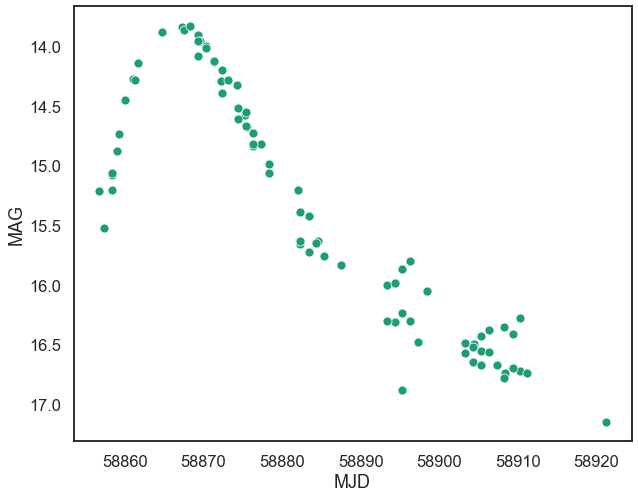

In [11]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='MJD', y='MAG',data=oneBand);
plt.gca().invert_yaxis()

In [12]:
#let's fit a quadratic to the rise and a linear to the fall (rough start for now)
peakTime = oneBand.loc[oneBand['MAG'] == np.min(oneBand['MAG']), 'MJD'].values[0]

In [13]:
#get the points with lowest error
oneBand.sort_values(by=['MJD'], inplace=True)
rise = oneBand[oneBand['MJD'] < peakTime]
peak = oneBand[np.abs(oneBand['MJD'] - peakTime) < 0.2]
#taking the point with lower error
fall = oneBand[oneBand['MJD'] > peakTime]

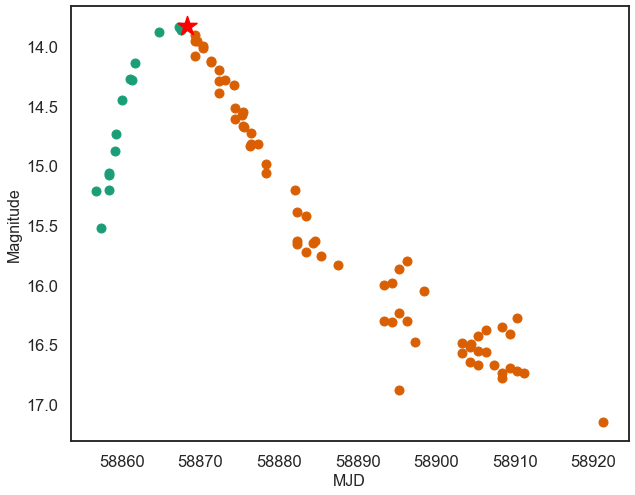

In [14]:
plt.figure(figsize=(10,8))
plt.plot(rise['MJD'], rise['MAG'], 'o')
plt.scatter(peak['MJD'], peak['MAG'], marker='*', s=400, zorder=100, c='r')
plt.plot(fall['MJD'], fall['MAG'], 'o')
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.gca().invert_yaxis()

In [15]:
import matplotlib.pyplot as plt
zRise = np.polyfit(rise['MJD'].values.astype(float), rise['MAG'].values, 2)
zFall = np.polyfit(fall['MJD'].values.astype(float), fall['MAG'].values, 2)

In [16]:
def fit(time):
    PT = peak['MJD'].values
    time = np.array(time)
    riseTimes = time[time <= PT]
    fallTimes = time[time > PT]
    riseMag = zRise[2] + zRise[1]*riseTimes + zRise[0]*riseTimes**2
    fallMag = zFall[2] + zFall[1]*fallTimes + zFall[0]*fallTimes**2 #+ zFall[0]*fallTimes**3
    mag = np.concatenate([riseMag, fallMag])
    return mag

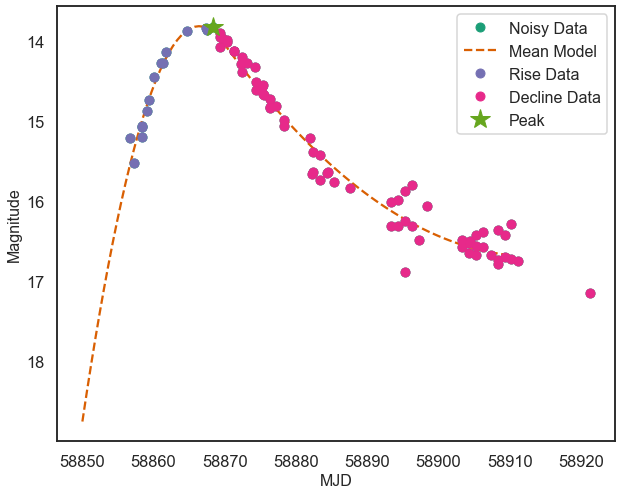

In [17]:
newTime = np.linspace(58850, 58910,num=100)
plt.figure(figsize=(10,8))
plt.plot(oneBand['MJD'].values, oneBand['MAG'].values, 'o', label='Noisy Data');
plt.plot(newTime, fit(newTime), '--',label='Mean Model');
plt.plot(rise['MJD'].values, rise['MAG'].values, 'o', label='Rise Data');
plt.plot(fall['MJD'].values, fall['MAG'].values, 'o', label='Decline Data');
plt.plot(peak['MJD'].values, peak['MAG'].values, '*', markersize=20, label='Peak');
plt.gca().invert_yaxis()
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.legend(fontsize=16);

In [18]:
import george
from george.modeling import Model

class MeanModel(Model):
    parameter_names = ('r1', 'r2', 'r3', 'f1', 'f2', 'f3')
    def get_parameter_vector(self):
        return np.array([self.r1, self.r2, self.r3, self.f1, self.f2, self.f3])
    def set_vector(self, vec):
        self.r1 = vec[0]
        self.r2 = vec[1]
        self.r3 = vec[2]
        self.f1 = vec[3]
        self.f2 = vec[4]
        self.f3 = vec[5]
        #k.set_parameter_vector(k.get_parameter_vector() + np.random.randn(2))
    def set_parameter_vector(self, vec): 
        return set_vector(self, vec)
    def get_value(self, time):
        PT = peak['MJD'].values
        time = np.array(time)
        riseTimes = time[time <= PT]
        fallTimes = time[time > PT]
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2 
        soln = np.concatenate([riseMag, fallMag])
        return soln

In [19]:
p0 = np.concatenate([zRise, zFall])

In [20]:
def lnprob(p):
    #let's make them all flat priors - 
    logBoundL = np.array([1.e-4, -1.e3, 1.e7, 1.e-4, -1.e3, 1.e6])
    logBoundR = np.array([1.e-3, -1.e2, 5.e7, 1.e-3, -1.e2, 5.e6])
    for i in np.arange(6):
        if (p[i] < logBoundL[i]) or (p[i] > logBoundR[i]):
            return -np.inf
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(oneBand['MAG'], quiet=True)

In [21]:
#oneBand_full = oneBand.copy()
#oneBand = oneBand_full.sample(int(len(oneBand_full)/4))
#oneBand = oneBand.sort_values(by=['MJD'])

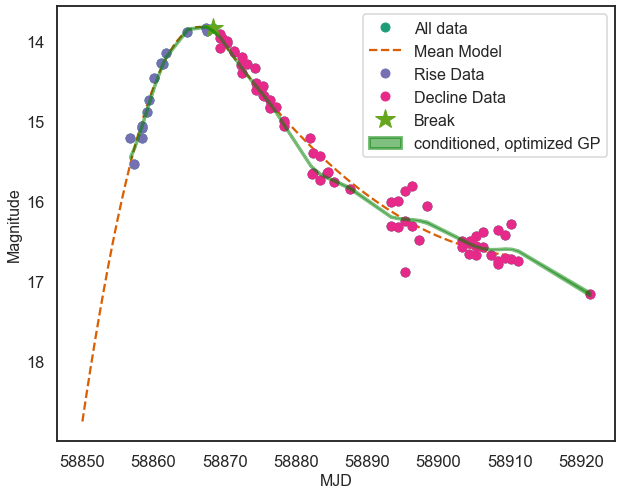

In [22]:
import scipy.optimize as op
from george import kernels

kernel = kernels.ExpSquaredKernel(50.0)

gp = george.GP(mean=MeanModel(r1=zRise[0], r2=zRise[1], r3=zRise[2], f1=zFall[0], f2=zFall[1], f3=zFall[2]), kernel=kernel)

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(oneBand['MAG'].values, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(oneBand['MAG'].values, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(oneBand['MJD'].values, oneBand['MAGERR'].values)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

ypred2, cov = gp.predict(oneBand['MAG'].values, oneBand['MJD'].values, return_cov=True)
std = np.sqrt(np.diag(cov))

# plot the data
plt.figure(figsize=(10,8))
plt.fill_between(oneBand['MJD'].values, ypred2+std, ypred2-std, color="g", lw=3, alpha=0.5, label='conditioned, optimized GP', zorder=100)
newTime = np.linspace(58850, 58910,num=100)
plt.plot(oneBand['MJD'].values, oneBand['MAG'].values, 'o', label='All data');
plt.plot(newTime, fit(newTime), '--',label='Mean Model');
plt.plot(rise['MJD'].values, rise['MAG'].values, 'o', label='Rise Data');
plt.plot(fall['MJD'].values, fall['MAG'].values, 'o', label='Decline Data');
plt.plot(peak['MJD'].values, peak['MAG'].values, '*', markersize=20, label='Break');
plt.gca().invert_yaxis()
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.legend(fontsize=16);

In [23]:
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, r1, r2, r3, f1, f2, f3):
        #Mean.__init__(self)
        self.r1 = r1
        self.r2 = r2
        self.r3 = r3
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.peak = peak
        
    def __call__(self, X):
        X = np.array(X)
        #PT = self.peak
        PT = peakTime
        riseTimes = X[X <= PT]
        fallTimes = X[X > PT]
        riseMag = self.r3 + self.r2*riseTimes + self.r1*riseTimes**2
        fallMag = self.f3 + self.f2*fallTimes + self.f1*fallTimes**2
        soln = tt.concatenate([riseMag, fallMag])
        return soln

In [24]:
peakTime

58868.274000000005

In [25]:
with pm.Model() as marginal_gp_model:

   # l = pm.Normal('l', 0.1, sigma=5, shape=1)
    cov_func = pm.gp.cov.ExpQuad(1, ls=50)

    # The scale of the white noise term can be provided,
    r1 = pm.Normal('r1', p0[0], sigma=10, shape=1)
    r2 = pm.Normal('r2', p0[1], sigma=10, shape=1)
    r3 = pm.Normal('r3', p0[2], sigma=10, shape=1)
    f1 = pm.Normal('f1', p0[3], sigma=10, shape=1)
    f2 = pm.Normal('f2', p0[4], sigma=10, shape=1)
    f3 = pm.Normal('f3', p0[5], sigma=10, shape=1)
    
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(MeanModel(r1=r1,r2=r2,r3=r3,f1=f1,f2=f2,f3=f3), cov_func=cov_func)
    y_ = gp.marginal_likelihood("y", X=oneBand['MJD'].values[:, None], y=oneBand['MAG'].values, noise=0.5) #noise=sigma)
    mp = pm.find_MAP()

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr

In [26]:
# new values from x=0 to x=20
X_new = np.linspace(58856.698, 58921.23906, 60)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

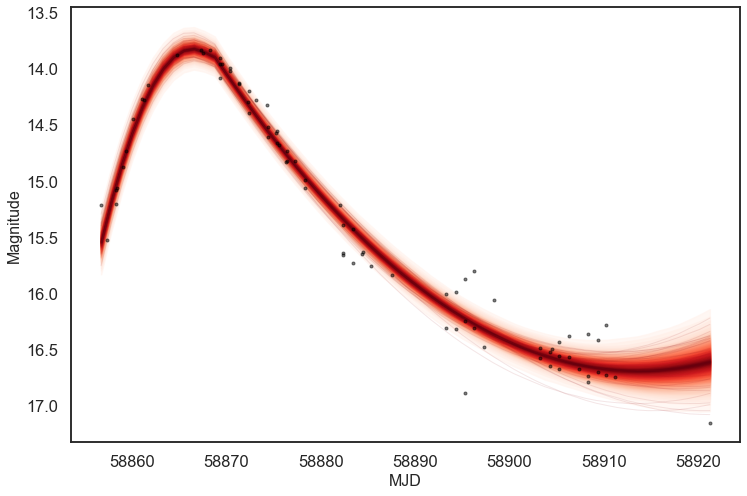

In [27]:
# plot the results
fig = plt.figure(figsize=(12,8)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(oneBand['MJD'], oneBand['MAG'], 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.gca().invert_yaxis()

Okay, now let's build up the data for the rest of the bands.

In [28]:
bands_list = [['rp', 'r-ZTF', 'r'], ['gp', 'g-ZTF', 'g'], ['B'], ['u', 'up'], ['U'], ['UVW2'], ['UVM2'], ['V'], ['i', 'ip']]
newbands_list = bands_list.copy()
cleaned_data = []
bands_idx = []
for i in np.arange(len(bands_list)):
    bands = bands_list[i]
    oneBand = data[data['FLT'].isin(bands)]
    newData = newData[newData['FLT'].isin(bands)]
    oneBand.sort_values(by=['MJD'], inplace=True)
    oneBand = oneBand[oneBand['MAGERR'] < 0.03]
    oneBand = oneBand[oneBand['MJD'] > 58800]

    #combine online data plus newly reduced Swope photometry
    oneBand = pd.concat([oneBand, newData], ignore_index=True)
    #make sure our observations are unique
    oneBand.drop_duplicates(subset=['MJD', 'MAG'], inplace=True)
    
    #only use if we have enough points for the fitting: 
    if len(oneBand) > 10:
        bands_idx.append(np.ones(len(oneBand))*i)
        cleaned_data.append(oneBand)
    else:
        newbands_list.remove(bands)
bands_idx = np.concatenate(bands_idx)
cleaned_df = pd.concat(cleaned_data, ignore_index=True)
bands_list = newbands_list

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [29]:
bands_list

[['rp', 'r-ZTF', 'r'], ['gp', 'g-ZTF', 'g'], ['B'], ['V'], ['i', 'ip']]

In [30]:
from pymc3.gp.util import plot_gp_dist

oneBand = cleaned_df[cleaned_df['FLT'].isin(bands)]
with pm.Model() as marginal_gp_model:

    cov_func = pm.gp.cov.ExpQuad(1, ls=8.)
    
    # The scale of the white noise term can be provided,
    r1 = pm.Normal('r1', p0[0], sigma=10, shape=5)
    r2 = pm.Normal('r2', p0[1], sigma=10, shape=5)
    r3 = pm.Normal('r3', p0[2], sigma=10, shape=5)
    f1 = pm.Normal('f1', p0[3], sigma=10, shape=5)
    f2 = pm.Normal('f2', p0[4], sigma=10, shape=5)
    f3 = pm.Normal('f3', p0[5], sigma=10, shape=5)
    
    gp = pm.gp.Marginal(MeanModel(r1=r1[0],r2=r2[0],r3=r3[0],f1=f1[0],f2=f2[0],f3=f3[0]), cov_func=cov_func)
    gp2 = pm.gp.Marginal(MeanModel(r1=r1[1],r2=r2[1],r3=r3[1],f1=f1[1],f2=f2[1],f3=f3[1]), cov_func=cov_func)
    gp3 = pm.gp.Marginal(MeanModel(r1=r1[2],r2=r2[2],r3=r3[2],f1=f1[2],f2=f2[2],f3=f3[2]), cov_func=cov_func)
    gp4 = pm.gp.Marginal(MeanModel(r1=r1[3],r2=r2[3],r3=r3[3],f1=f1[3],f2=f2[3],f3=f3[3]), cov_func=cov_func)
    gp5 = pm.gp.Marginal(MeanModel(r1=r1[4],r2=r2[4],r3=r3[4],f1=f1[4],f2=f2[4],f3=f3[4]), cov_func=cov_func)
 
    y_ = gp.marginal_likelihood("y", X=cleaned_data[0]['MJD'].values[:, None], y=cleaned_data[0]['MAG'].values, noise=0.05) #noise=sigma[0])
    mp = pm.find_MAP()

    y2_ = gp2.marginal_likelihood("y2", X=cleaned_data[1]['MJD'].values[:, None], y=cleaned_data[1]['MAG'].values, noise=0.05) #noise=sigma[1])
    mp2 = pm.find_MAP()
    
    y3_ = gp3.marginal_likelihood("y3", X=cleaned_data[2]['MJD'].values[:, None], y=cleaned_data[2]['MAG'].values, noise=0.05) #noise=sigma[2])
    mp3 = pm.find_MAP()

    y4_ = gp4.marginal_likelihood("y4", X=cleaned_data[3]['MJD'].values[:, None], y=cleaned_data[3]['MAG'].values, noise=0.05) #noise=sigma[3])
    mp4 = pm.find_MAP()

    y5_ = gp5.marginal_likelihood("y5", X=cleaned_data[4]['MJD'].values[:, None], y=cleaned_data[4]['MAG'].values, noise=0.05) #noise=sigma[4])
    mp5 = pm.find_MAP()

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -335.91, ||grad|| = 258.11: 100%|██████████| 37/37 [00:00<00:00, 1090.48it/s]  
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

100%|██████████| 1000/1000 [00:09<00:00, 105.91it/s]


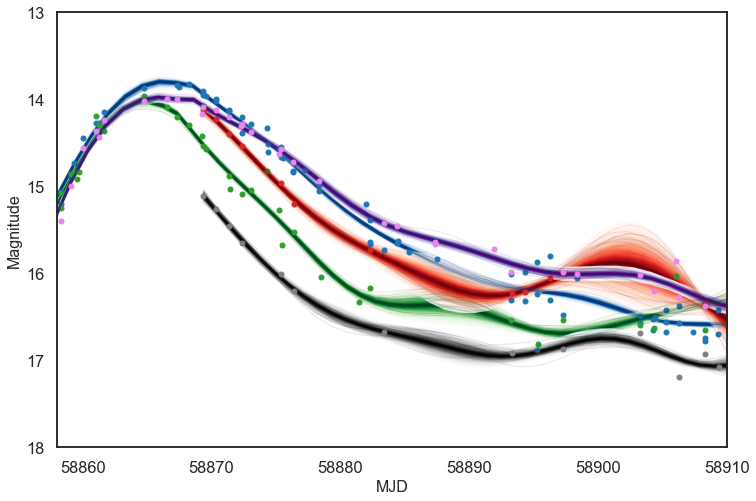

In [31]:
X_new = np.linspace(np.min(cleaned_data[0]['MJD']), np.max(cleaned_data[0]['MJD']), 50)[:,None]
X_new2 = np.linspace(np.min(cleaned_data[1]['MJD']), np.max(cleaned_data[1]['MJD']), 50)[:,None]
X_new3 = np.linspace(np.min(cleaned_data[2]['MJD']), np.max(cleaned_data[2]['MJD']), 50)[:,None]
X_new4 = np.linspace(np.min(cleaned_data[3]['MJD']), np.max(cleaned_data[3]['MJD']), 50)[:,None]
X_new5 =np.linspace(np.min(cleaned_data[4]['MJD']), np.max(cleaned_data[4]['MJD']), 50)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    f_pred2 = gp2.conditional("f_pred2", X_new2)
    f_pred3 = gp3.conditional("f_pred3", X_new3)
    f_pred4 = gp4.conditional("f_pred4", X_new4)
    f_pred5 = gp5.conditional("f_pred5", X_new5)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=1000)
    pred_samples2 = pm.sample_posterior_predictive([mp2], vars=[f_pred2], samples=1000)
    pred_samples3 = pm.sample_posterior_predictive([mp3], vars=[f_pred3], samples=1000)
    pred_samples4 = pm.sample_posterior_predictive([mp4], vars=[f_pred4], samples=1000)
    pred_samples5 = pm.sample_posterior_predictive([mp5], vars=[f_pred5], samples=1000)
    
# plot the results
fig = plt.figure(figsize=(12,8)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples["f_pred"], X_new, palette = 'Blues');
plt.plot(cleaned_data[0]['MJD'], cleaned_data[0]['MAG'], 'ok', ms=5, label="Observed data", color='tab:blue');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples2["f_pred2"], X_new2, palette = 'Greens');
plt.plot(cleaned_data[1]['MJD'], cleaned_data[1]['MAG'], 'ok', ms=5, label="Observed data", color='tab:green');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples3["f_pred3"], X_new3, palette = 'Greys');
plt.plot(cleaned_data[2]['MJD'], cleaned_data[2]['MAG'], 'ok', ms=5, label="Observed data", color='grey');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples4["f_pred4"], X_new4, palette = 'Reds');
plt.plot(cleaned_data[3]['MJD'], cleaned_data[3]['MAG'], 'ok', ms=5, label="Observed data", color='tab:red');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples5["f_pred5"], X_new5, palette = 'Purples');
plt.plot(cleaned_data[4]['MJD'], cleaned_data[4]['MAG'], 'ok', ms=5, label="Observed data", color='violet');

plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim((58858, 58910))
plt.ylim((18, 13))
plt.show()

But, if we're going to use this data for bolometric fitting, we need to evaluate it along the same xgrid: 

In [32]:
X_new = np.linspace(np.min(cleaned_data[0]['MJD']), np.max(cleaned_data[0]['MJD']), 50)[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred6 = gp.conditional("f_pred6", X_new)
    f_pred7 = gp2.conditional("f_pred7", X_new)
    f_pred8 = gp3.conditional("f_pred8", X_new)
    f_pred9 = gp4.conditional("f_pred9", X_new)
    f_pred10 = gp5.conditional("f_pred10", X_new)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples6 = pm.sample_posterior_predictive([mp], vars=[f_pred6], samples=1000)
    pred_samples7 = pm.sample_posterior_predictive([mp2], vars=[f_pred7], samples=1000)
    pred_samples8 = pm.sample_posterior_predictive([mp3], vars=[f_pred8], samples=1000)
    pred_samples9 = pm.sample_posterior_predictive([mp4], vars=[f_pred9], samples=1000)
    pred_samples10 = pm.sample_posterior_predictive([mp5], vars=[f_pred10], samples=1000)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 1000/1000 [00:10<00:00, 97.03it/s]


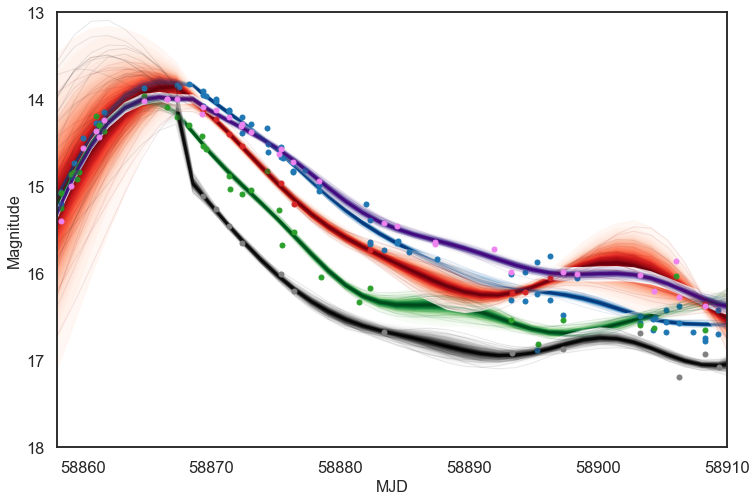

In [33]:
# plot the results
fig = plt.figure(figsize=(12,8)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples6["f_pred6"], X_new, palette = 'Blues');
plt.plot(cleaned_data[0]['MJD'], cleaned_data[0]['MAG'], 'ok', ms=5, label="Observed data", color='tab:blue');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples7["f_pred7"], X_new, palette = 'Greens');
plt.plot(cleaned_data[1]['MJD'], cleaned_data[1]['MAG'], 'ok', ms=5, label="Observed data", color='tab:green');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples8["f_pred8"], X_new, palette = 'Greys');
plt.plot(cleaned_data[2]['MJD'], cleaned_data[2]['MAG'], 'ok', ms=5, label="Observed data", color='grey');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples9["f_pred9"], X_new, palette = 'Reds');
plt.plot(cleaned_data[3]['MJD'], cleaned_data[3]['MAG'], 'ok', ms=5, label="Observed data", color='tab:red');

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples10["f_pred10"], X_new, palette = 'Purples');
plt.plot(cleaned_data[4]['MJD'], cleaned_data[4]['MAG'], 'ok', ms=5, label="Observed data", color='violet');

plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim((58858, 58910))
plt.ylim((18, 13))
plt.show()

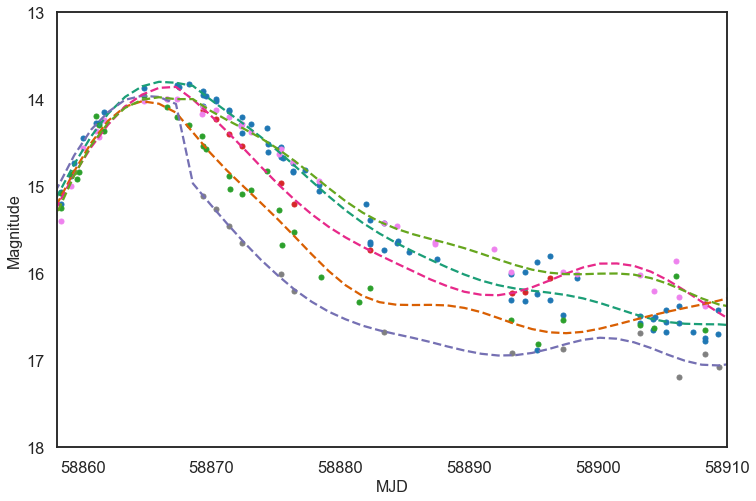

In [43]:
# plot the results
fig = plt.figure(figsize=(12,8)); ax = fig.gca()

plt.plot(cleaned_data[0]['MJD'], cleaned_data[0]['MAG'], 'ok', ms=5, label="Observed data", color='tab:blue');
plt.plot(cleaned_data[1]['MJD'], cleaned_data[1]['MAG'], 'ok', ms=5, label="Observed data", color='tab:green');
plt.plot(cleaned_data[2]['MJD'], cleaned_data[2]['MAG'], 'ok', ms=5, label="Observed data", color='grey');
plt.plot(cleaned_data[3]['MJD'], cleaned_data[3]['MAG'], 'ok', ms=5, label="Observed data", color='tab:red');
plt.plot(cleaned_data[4]['MJD'], cleaned_data[4]['MAG'], 'ok', ms=5, label="Observed data", color='violet');

gpLC_r = np.median(pred_samples6['f_pred6'], axis=0)
gpLC_g = np.median(pred_samples7['f_pred7'], axis=0)
gpLC_B = np.median(pred_samples8['f_pred8'], axis=0)
gpLC_V = np.median(pred_samples9['f_pred9'], axis=0)
gpLC_i = np.median(pred_samples10['f_pred10'], axis=0)

gpLCr_std = np.std(pred_samples6['f_pred6'], axis=0)
gpLCg_std = np.std(pred_samples7['f_pred7'], axis=0)
gpLCB_std = np.std(pred_samples8['f_pred8'], axis=0)
gpLCV_std = np.std(pred_samples9['f_pred9'], axis=0)
gpLCi_std = np.std(pred_samples10['f_pred10'], axis=0)

bol_std = np.sqrt(gpLCr_std**2 + gpLCg_std**2 + gpLCB_std**2 + gpLCV_std**2 + gpLCi_std**2)

#['r', 'g', 'B', 'V', 'i']
plt.plot(X_new, gpLC_r, '--' )
plt.plot(X_new, gpLC_g, '--')
plt.plot(X_new, gpLC_B, '--')
plt.plot(X_new, gpLC_V, '--')
plt.plot(X_new, gpLC_i, '--')

plt.xlabel("MJD",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.gca().invert_yaxis()
plt.xlim((58858, 58910))
plt.ylim((18, 13))
plt.show()

In [106]:
#50 points along the lightcurve, 1000 lightcurves
#wavelengths are the centers of each band
#fluxes are the values 

wavelengths = np.array([658, 464, 445, 551, 806])*10 #in Angstroms
bol = []
for i in np.arange(len(X_new)):
    mags = np.array([gpLC_r[i], gpLC_g[i], gpLC_B[i], gpLC_V[i], gpLC_i[i]])
    fluxes = 10**((-mags)/2.5) # normalized flux units - do we need to apply the zeropoint??
    fluxes[0] *= 217.7 #r correction
    fluxes[1] *= 217.7 #g correction, just using r for now
    fluxes[2] *= 632 #B correction
    fluxes[3] *= 363.1 #V correction
    fluxes[4] *= 112.6 #i correction
    fluxes *= 1.e-11 #ergs cm^-2 s^-1 Angstroms^-1
    bol.append(np.trapz(fluxes, wavelengths))

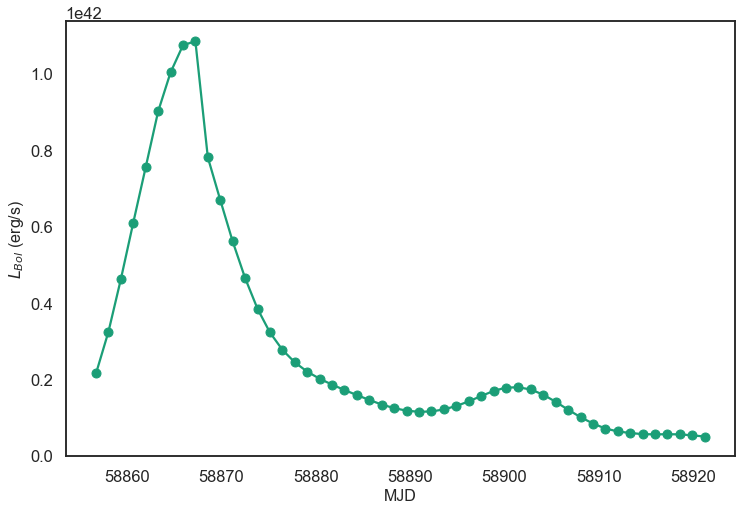

In [108]:
fig = plt.figure(figsize=(12,8)); 
ax = fig.gca()

bol_lum = np.array(bol) * 4 * np.pi * (7.004e25)**2 #ergs cm^-2 s^-1

# z~ 0.005251 corresponds to a distance of 22.7 Mpc
plt.plot(X_new, bol_lum, 'o-')
plt.xlabel("MJD",fontsize=16);
plt.ylabel(r"$L_{Bol}$ (erg/s)",fontsize=16);

Finally, to get the temperature over time, we assume a blackbody and do the conversion:

In [164]:
bol_lumJ = 1.e-7*bol_lum

#Lbol = 4 * pi * sigma * T^4 R^2
def bb_Lbol(R, T):
    sigma = 5.670374419e-8 #W m-2 K-4#the stefan-boltzmann constant
    return 4 * np.pi * sigma * T**4 * R**2

#YOU NEED TO BE PROPOGATING ERROR TERMS BETTER!

# the log-likelihood for all galaxies simultaneously
def neg_log_like(theta, Ltrue, sig_true):    
    chisq = np.sum((bb_Lbol(theta[0], theta[1]) - Ltrue)**2/(sig_true**2))
    return -0.5*chisq

# the log of the prior for the slope and the intercept of our lines.
# only if the prior makes sense for all lines simultaneously do we 
# accept it
def log_prior(theta):
    if (1.e8 < theta[0] < 1.e13) and (1.e3 < theta[1] < 5.e4): #in meters and Kelvin
        return 0
    else:
        return -np.inf

# the posterior is the combination of the prior and the likelihood for each of our 9 galaxies, simultaneously fit
def log_posterior(theta, ttrue, Ltrue, sig_true):
    # add in the 0 y-intercept for galaxy NGC 4258 - theta doesn't leave this function after this
    # so we're fine
    return log_prior(theta)+neg_log_like(theta, Ltrue, sig_true)

In [169]:
import emcee
theta_init = [1.e9, 4000]
pos = theta_init + 1.e2*np.random.randn(1000, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X_new[0], bol_lumJ[0], bol_std[0]))
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:28<00:00, 69.33it/s]


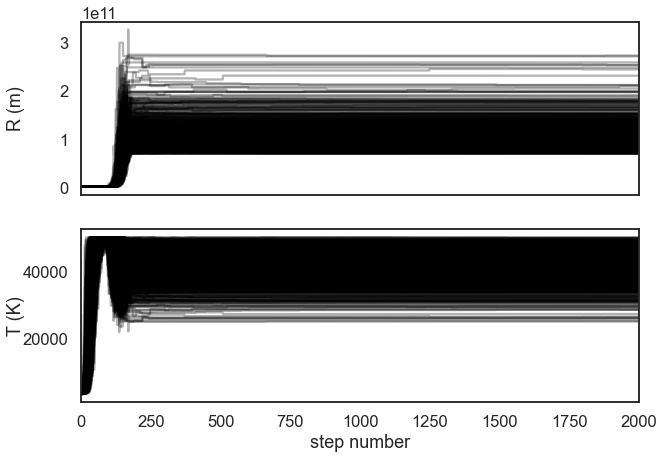

In [170]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"R (m)", "T (K)"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

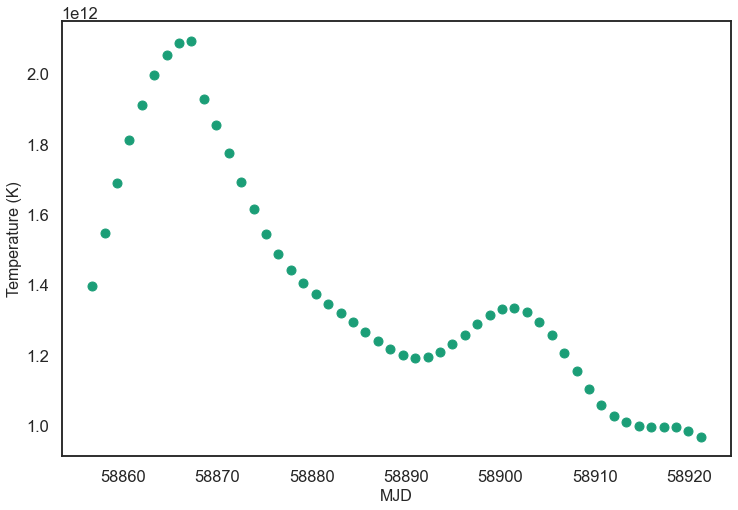

In [119]:
fig = plt.figure(figsize=(12,8)); 
plt.plot(X_new, temp, 'o')
plt.xlabel("MJD",fontsize=16);
plt.ylabel("Temperature (K)",fontsize=16);